In [1]:
!pip install wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.9/19.9 MB 931.4 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.6/207.6 kB 1.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.8/417.8 kB 1.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.7/431.7 kB 978.6 kB/s eta 0:00:00 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 954.8 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.9/336.9 kB 1.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 2.9 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.9.0
    Uninstalling typing_extensions-4.9.0:
      Successfully uninstalled typing_extensions-4.9.0


In [1]:
import os
os.environ["WANDB_API_KEY"] = "dc32cff91f690c591c4e92185a7d97c8e9f96630"

import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: wsincos (wsincos1025) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [2]:
import os,PIL 
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torch 
from torch import nn 
import torchvision 
from torchvision import transforms
import datetime
import wandb 
from argparse import Namespace

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
config = Namespace(
    project_name = 'wandb_demo',
    batch_size = 256,
    hidden_layer_width = 64,
    dropout_p = 0.1,
    lr = 1e-4,
    optim_type = 'Adam',
    epochs = 15,
    ckpt_path = 'checkpoint.pt'
)

In [4]:
def create_dataloaders(config):
    transform = transforms.Compose([transforms.ToTensor()])
    ds_train = torchvision.datasets.MNIST(root="./mnist/",train=True,download=True,transform=transform)
    ds_val = torchvision.datasets.MNIST(root="./mnist/",train=False,download=True,transform=transform)

    ds_train_sub = torch.utils.data.Subset(ds_train, indices=range(0, len(ds_train), 5))
    dl_train =  torch.utils.data.DataLoader(ds_train_sub, batch_size=config.batch_size, shuffle=True,
                                            num_workers=2,drop_last=True)
    dl_val =  torch.utils.data.DataLoader(ds_val, batch_size=config.batch_size, shuffle=False, 
                                          num_workers=2,drop_last=True)
    return dl_train,dl_val

def create_net(config):
    net = nn.Sequential()
    net.add_module("conv1",nn.Conv2d(in_channels=1,out_channels=config.hidden_layer_width,kernel_size = 3))
    net.add_module("pool1",nn.MaxPool2d(kernel_size = 2,stride = 2)) 
    net.add_module("conv2",nn.Conv2d(in_channels=config.hidden_layer_width,
                                     out_channels=config.hidden_layer_width,kernel_size = 5))
    net.add_module("pool2",nn.MaxPool2d(kernel_size = 2,stride = 2))
    net.add_module("dropout",nn.Dropout2d(p = config.dropout_p))
    net.add_module("adaptive_pool",nn.AdaptiveMaxPool2d((1,1)))
    net.add_module("flatten",nn.Flatten())
    net.add_module("linear1",nn.Linear(config.hidden_layer_width,config.hidden_layer_width))
    net.add_module("relu",nn.ReLU())
    net.add_module("linear2",nn.Linear(config.hidden_layer_width,10))
    net.to(device)
    return net 

def train_epoch(model,dl_train,optimizer):
    model.train()
    for step, batch in enumerate(dl_train):
        features,labels = batch
        features,labels = features.to(device),labels.to(device)

        preds = model(features)
        loss = nn.CrossEntropyLoss()(preds,labels)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
    return model

def eval_epoch(model,dl_val):
    model.eval()
    accurate = 0
    num_elems = 0
    for batch in dl_val:
        features,labels = batch
        features,labels = features.to(device),labels.to(device)
        with torch.no_grad():
            preds = model(features)
        predictions = preds.argmax(dim=-1)
        accurate_preds =  (predictions==labels)
        num_elems += accurate_preds.shape[0]
        accurate += accurate_preds.long().sum()

    val_acc = accurate.item() / num_elems
    return val_acc

wandb想要将实验的数据上传，实际上只需要三步
- wandb.init(project, name)# 选择好你的项目和你这个entity的具体名字
> init中还可以以字典的形式将你的config传入进去，config= my_dict_config  
> 如果选择save_code，就可以将本次实验的代码保存到Artifacts
- wandb.log(dict) # 将你需要记录的参数传到服务器，这里一般就是你的acc、epoch等信息
- wandb.finish() # 结束wandb使用

In [ ]:
def train(config = config):
    dl_train, dl_val = create_dataloaders(config)
    model = create_net(config); 
    optimizer = torch.optim.__dict__[config.optim_type](params=model.parameters(), lr=config.lr)
    #======================================================================
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    wandb.init(project=config.project_name, config = config.__dict__, name = nowtime, save_code=True)
    model.run_id = wandb.run.id

    model.best_metric = -1.0
    for epoch in range(1,config.epochs+1):
        model = train_epoch(model,dl_train,optimizer)
        val_acc = eval_epoch(model,dl_val)
        if val_acc>model.best_metric:
            model.best_metric = val_acc
            torch.save(model.state_dict(),config.ckpt_path)   
        nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        print(f"epoch【{epoch}】@{nowtime} --> val_acc= {100 * val_acc:.2f}%")
        wandb.log({'epoch':epoch, 'val_acc': val_acc, 'best_val_acc':model.best_metric})     
    wandb.finish()
    return model   

In [6]:
model = train(config)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:14<00:00, 685602.41it/s] 


Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 60757.87it/s]


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:06<00:00, 238005.59it/s]


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 4004735.92it/s]


Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



epoch【1】@2025-03-23 13:44:09 --> val_acc= 29.47%
epoch【2】@2025-03-23 13:44:20 --> val_acc= 52.32%
epoch【3】@2025-03-23 13:44:32 --> val_acc= 73.10%
epoch【4】@2025-03-23 13:44:44 --> val_acc= 80.18%
epoch【5】@2025-03-23 13:44:56 --> val_acc= 83.23%
epoch【6】@2025-03-23 13:45:08 --> val_acc= 86.36%
epoch【7】@2025-03-23 13:45:20 --> val_acc= 88.73%
epoch【8】@2025-03-23 13:45:32 --> val_acc= 90.18%
epoch【9】@2025-03-23 13:45:44 --> val_acc= 91.63%
epoch【10】@2025-03-23 13:45:55 --> val_acc= 92.17%
epoch【11】@2025-03-23 13:46:07 --> val_acc= 92.83%
epoch【12】@2025-03-23 13:46:18 --> val_acc= 93.40%
epoch【13】@2025-03-23 13:46:30 --> val_acc= 93.74%
epoch【14】@2025-03-23 13:46:41 --> val_acc= 94.10%
epoch【15】@2025-03-23 13:46:52 --> val_acc= 94.38%


best_val_acc,▁▃▆▆▇▇▇████████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
val_acc,▁▃▆▆▇▇▇████████
best_val_acc,0.94381
epoch,15
val_acc,0.94381


刚刚我们使用了wandb.finish()，就结束了wanbd的使用，如果想要重新恢复这个项目的使用，而不是重新创建一个新的任务，我们就可以在重新初始化，在初始化的时候传入我们原本的id

在刚刚我们训练的时候，提前将这一次wandb.run.id存储到model.run_id中，现在我们可以利用这个id对wandb重新进行初始化，需要注意的是必须要置顶resume,因为resume默认的是'never'

In [13]:
run = wandb.init(project="wandb_demo", id=model.run_id, resume='must')

如果想要存储代码、模型、或者数据集到wandb中，那就需要调用Artifact，这个是wandb存储东西的地方

In [14]:
# save dataset 
arti_dataset = wandb.Artifact('mnist', type='dataset') # 创建一个名为 'mnist' 的 Artifact，对它的类型标注为 'dataset'
arti_dataset.add_dir('mnist/') # 将本地名为 'mnist/' 的整个文件夹添加到这个 artifact 中
wandb.log_artifact(arti_dataset) # 正式将这个 artifact 上传到当前的 wandb run 中

# save code 
arti_code = wandb.Artifact('ipynb', type='code')
arti_code.add_file('./wandb.ipynb')
wandb.log_artifact(arti_code)

# save model
arti_model = wandb.Artifact('demo_cnn_model', type='model')
arti_model.add_file(config.ckpt_path)
wandb.log_artifact(arti_model)
wandb.finish() 

wandb: Adding directory to artifact (./mnist)... Done. 0.1s


best_val_acc,0.94381
epoch,15
val_acc,0.94381


如果想要分析具体的数据，一种做法是用matplotlib，但是也可以通过wandb实现

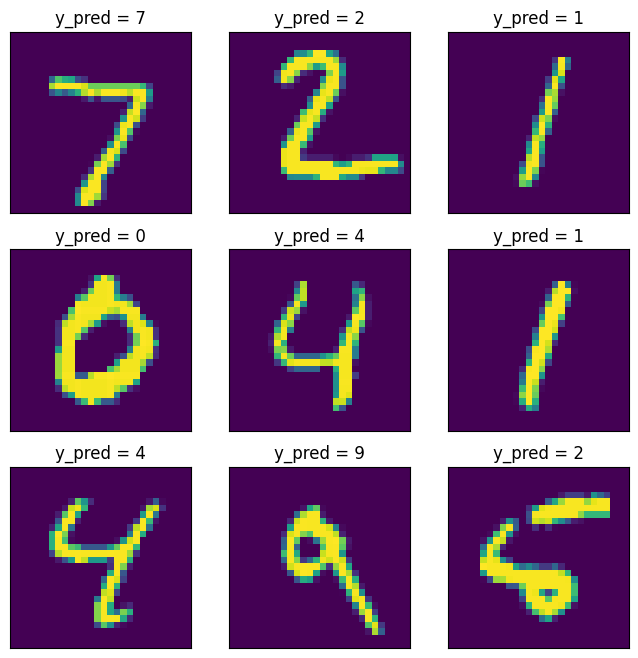

In [15]:
import matplotlib.pyplot as plt 

transform = transforms.Compose([transforms.ToTensor()])
ds_train = torchvision.datasets.MNIST(root="./mnist/",train=True,download=True,transform=transform)
ds_val = torchvision.datasets.MNIST(root="./mnist/",train=False,download=True,transform=transform)
    
# visual the  prediction
device = None
for p in model.parameters():
    device = p.device
    break

plt.figure(figsize=(8,8)) 
for i in range(9):
    img,label = ds_val[i]
    tensor = img.to(device)
    y_pred = torch.argmax(model(tensor[None,...])) 
    img = img.permute(1,2,0)
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title("y_pred = %d"%y_pred)
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()    

如果想要使用wandb，就需要用以下步骤
- my_table = wandb.Table(columns=[...]) 创建一个table
- 将columns中的内容都得到，如果有图片就通过input_img = wandb.Image(img)转化为wandb的图片形式
> 想要将tensor data转化为图像，首先第一步，要这样转化:(C, H, W) -> (H, W, C)  
> 这里先转化为figure，然后再转化，是因为直接从图片转化过去，没有坐标轴、title等信息，可以先通过figure设定一些东西，再从figure转化过去，就会好很多
- my_table.add_data(...) 将内容加入到table中

In [ ]:
run = wandb.init(project='wandb_demo', id=model.run_id, resume='must')

def data2fig(data):
    import matplotlib.pyplot as plt 
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.imshow(data)
    ax.set_xticks([])
    ax.set_yticks([]) 
    return fig

def fig2img(fig):
    import io,PIL
    buf = io.BytesIO()
    fig.savefig(buf) 
    # 把缓冲区的“指针”回到起始位置，为了接下来能正确读取图像数据。
    buf.seek(0)
    img = PIL.Image.open(buf)
    return img

from tqdm import tqdm 
good_cases = wandb.Table(columns = ['Image','GroundTruth','Prediction'])
bad_cases = wandb.Table(columns = ['Image','GroundTruth','Prediction'])

# 找到50个good cases 和 50 个bad cases
plt.close()

for i in tqdm(range(1000)):
    features,label = ds_val[i]
    tensor = features.to(device)
    y_pred = torch.argmax(model(tensor[None,...])) 
    
    # log badcase
    if y_pred!=label:
        if len(bad_cases.data)<50:
            data = features.permute(1,2,0).numpy()
            input_img = wandb.Image(fig2img(data2fig(data)))
            bad_cases.add_data(input_img,label,y_pred)
            
    # log goodcase
    else:
        if len(good_cases.data)<50:
            data = features.permute(1,2,0).numpy()
            input_img = wandb.Image(fig2img(data2fig(data)))
            good_cases.add_data(input_img,label,y_pred)

wandb.log({'good_cases':good_cases,'bad_cases':bad_cases})
wandb.finish()

1


# 可视化调参

使用sweep的3步骤  
1. 配置sweep_config
2. 初始化sweep controller
3. 启动sweep agent

## 1. 配置config
Sweep支持如下3种调优算法:

(1)网格搜索：grid. 遍历所有可能得超参组合，只在超参空间不大的时候使用，否则会非常慢。

(2)随机搜索：random. 每个超参数都选择一个随机值，非常有效，一般情况下建议使用。

(3)贝叶斯搜索：bayes. 创建一个概率模型估计不同超参数组合的效果，采样有更高概率提升优化目标的超参数组合。对连续型的超参数特别有效，但扩展到非常高维度的超参数时效果不好。

In [18]:
sweep_config = {
    'method': 'random'
    }

设置优化指标，以及优化方向。

sweep agents 通过 wandb.log 的形式向 sweep controller 传递优化目标的值

In [19]:
metric = {
    'name': 'val_acc',
    'goal': 'maximize'   
    }
sweep_config['metric'] = metric

In [ ]:
sweep_config['parameters'] = {}

# 固定不变的超参
sweep_config['parameters'].update({
    'project_name':{'value':'wandb_demo'},
    'epochs': {'value': 10},
    'ckpt_path': {'value':'checkpoint.pt'}})

# 离散型分布超参
sweep_config['parameters'].update({
    'optim_type': {
        'values': ['Adam', 'SGD','AdamW']
        },
    'hidden_layer_width': {
        'values': [16,32,48,64,80,96,112,128]
        }
    })

# 连续型分布超参
sweep_config['parameters'].update({
    'lr': {
        'distribution': 'log_uniform_values',
        'min': 1e-6,
        'max': 0.1
      },
    
    'batch_size': {
        'distribution': 'q_uniform',
        'q': 8,
        'min': 32,
        'max': 256,
      },
    
    'dropout_p': {
        'distribution': 'uniform',
        'min': 0,
        'max': 0.6,
      }
})


In [22]:
sweep_config['early_terminate'] = {
    'type':'hyperband',
    'min_iter':3,
    'eta':2,
    's':3
} #在step=3, 6, 12 时考虑是否剪枝


In [23]:
from pprint import pprint
pprint(sweep_config)

{'early_terminate': {'eta': 2, 'min_iter': 3, 's': 3, 'type': 'hyperband'},
 'method': 'random',
 'metric': {'goal': 'maximize', 'name': 'val_acc'},
 'parameters': {'batch_size': {'distribution': 'q_uniform',
                               'max': 256,
                               'min': 32,
                               'q': 8},
                'ckpt_path': {'value': 'checkpoint.pt'},
                'dropout_p': {'distribution': 'uniform', 'max': 0.6, 'min': 0},
                'epochs': {'value': 10},
                'hidden_layer_width': {'values': [16,
                                                  32,
                                                  48,
                                                  64,
                                                  80,
                                                  96,
                                                  112,
                                                  128]},
                'lr': {'distribution': 'log_uniform_

## 2.初始化sweep.controller

In [24]:
sweep_id = wandb.sweep(sweep_config, project=config.project_name)

Create sweep with ID: ej1eukrg
Sweep URL: https://wandb.ai/wsincos1025/wandb_demo/sweeps/ej1eukrg


## 3. 使用agent

In [30]:
wandb.agent(sweep_id, train, count=5)

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3tv0t8oj with config:
wandb: 	batch_size: 168
wandb: 	ckpt_path: checkpoint.pt
wandb: 	dropout_p: 0.35290351777907875
wandb: 	epochs: 10
wandb: 	hidden_layer_width: 96
wandb: 	lr: 4.793596396745288e-05
wandb: 	optim_type: SGD
wandb: 	project_name: wandb_demo
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


wandb: ERROR Run 3tv0t8oj errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/opt/anaconda3/envs/pytorch/lib/python3.12/asyncio/tasks.py", line 520, in wait_for
wandb: ERROR     return await fut
wandb: ERROR            ^^^^^^^^^
wandb: ERROR   File "/opt/anaconda3/envs/pytorch/lib/python3.12/asyncio/locks.py", line 212, in wait
wandb: ERROR     await fut
wandb: ERROR asyncio.exceptions.CancelledError
wandb: ERROR 
wandb: ERROR The above exception was the direct cause of the following exception:
wandb: ERROR 
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/opt/anaconda3/envs/pytorch/lib/python3.12/site-packages/wandb/sdk/mailbox/response_handle.py", line 109, in wait_async
wandb: ERROR     await asyncio.wait_for(evt.wait(), timeout=timeout)
wandb: ERROR   File "/opt/anaconda3/envs/pytorch/lib/python3.12/asyncio/tasks.py", line 519, in wait_for
wandb: ERROR     async with timeouts.timeout(timeout):
wandb: ERROR   File "/opt/anaconda3/envs/